# Generative Adversarial Set Transformers

The following notebook provides a basic implementation of the GAST framework from the paper: *[Generative Adversarial Set Transformers](https://www.ml.informatik.tu-darmstadt.de/papers/stelzner2020ood_gast.pdf)*.


## Conversion Checklist

- [X] Use hinge-loss as described in the paper
- [X] Randomly sample the initial set
- [ ] Varying Set Cardinalities

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import time

from IPython import display

import dl_utils.tf as tf_utils
import settransformer as sf

import common

## Configuration

In [2]:
strategy = tf_utils.strategy("gpu:0")
# strategy = tf_utils.strategy(multi_gpu=True)

In [161]:
# Use the original implementation of multihead attention
# from the official Pytorch implementation of set transformer
sf.config("use_keras_mha", True)

True

## MNIST Dataset

Load the MNIST pointcloud dataset and set up the Tensorflow dataset.

In [162]:
window = (-3, 3) # preview viewport range
# BUFFER_SIZE = len(x_train)
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [5]:
NUM_POINTS = 500
BUFFER_SIZE = 20

mnist_data_generator = common.MultiprocessMnistGenerator(
    batch_size=GLOBAL_BATCH_SIZE,
    num_points=NUM_POINTS,
    buffer_size=BUFFER_SIZE,
    num_workers=4,
    threshold=50)

train_dataset = tf.data.Dataset.from_generator(
    mnist_data_generator.generator,
    output_types=(tf.float32, tf.int32),
    output_shapes=(
        tf.TensorShape([GLOBAL_BATCH_SIZE, NUM_POINTS, 2]),
        tf.TensorShape([GLOBAL_BATCH_SIZE,])))

In [6]:
# train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE)
train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)

In [7]:
mnist_data_generator.start()

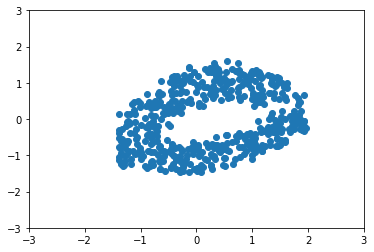

In [8]:
x_train = next(iter(train_dist_dataset))[0][0]
plt.scatter(*x_train.numpy().T)
plt.xlim(window)
plt.ylim(window)
plt.show()

## Layer Implementations

The following cells provide the layer implementations required for the GAST framework. The ISE layer specified in the paper has been implemented into the *set transformers* implementation as noted in the repository dependencies.

In [163]:
class ConditionedISAB(keras.layers.Layer):
    def __init__(self, embed_dim, dim_cond, num_heads, num_anchors):
        super(ConditionedISAB, self).__init__()
        self.embed_dim = embed_dim
        self.num_anchors = num_anchors
        self.mab1 = sf.MAB(embed_dim, num_heads)
        self.mab2 = sf.MAB(embed_dim, num_heads)
        self.anchor_predict = keras.models.Sequential([
            keras.layers.Dense(
                num_anchors*embed_dim,
                input_shape=(dim_cond,),
                activation="gelu"),
            tfa.layers.SpectralNormalization(
                keras.layers.Dense(num_anchors*embed_dim)),
            keras.layers.Reshape((num_anchors, embed_dim))
        ])
        
    def call(self, inp):
        inducing_points = self.anchor_predict(inp[1])
        h = self.mab1(inducing_points, inp[0])
        return self.mab2(inp[0], h)

In [164]:
class SampleSet(keras.layers.Layer):
    def __init__(self, max_set_size, embed_dim):
        super(SampleSet, self).__init__()
        self.max_set_size = max_set_size
        self.embed_dim = embed_dim
        
    def build(self, input_shape):
        self.mu = self.add_weight(
            shape=(self.max_set_size, self.embed_dim),
            initializer="random_normal",
            trainable=True,
            name="mu")
        self.sigma = self.add_weight(
            shape=(self.max_set_size, self.embed_dim),
            initializer="random_normal",
            trainable=True,
            name="sigma")
        
    def call(self, n):
        batch_size = tf.shape(n)[0]
        n = tf.squeeze(tf.cast(n[0], dtype=tf.int32)) # all n should be the same, take one
#         n = self.max_set_size
        mean = self.mu
        variance = tf.square(self.sigma)
        
        # Sample a random initial set of max size
        initial_set = tf.random.normal((batch_size, self.max_set_size, self.embed_dim), mean, variance)

        # Pick random indices without replacement
        _, random_indices = tf.nn.top_k(tf.random.uniform(shape=(batch_size, self.max_set_size)), n)        
        batch_indices = tf.reshape(tf.repeat(tf.range(batch_size), n), (-1, n))
        indices = tf.stack([batch_indices, random_indices], axis=2)
        
        # Sample the set
        sampled_set = tf.gather_nd(initial_set, indices)
        
        return sampled_set

## Model Architecture

![Model Architecture](./images/architecture.png)

In [165]:
NOISE_DIM = 64
EMBED_DIM = 64
LATENT_DIM = EMBED_DIM
NUM_HEADS = 4
NUM_ANCHORS = 24
MAX_SET_SIZE = x_train.shape[1]

### Generator

![Generator Transformer](./images/gen_layer.png)

In [177]:
with strategy.scope():
    noise = keras.layers.Input((LATENT_DIM,))
    label = keras.layers.Input((1,), dtype=tf.float32)
    cardinality = keras.layers.Input((1,), dtype=tf.int32)
    
    condition = keras.layers.Embedding(10, LATENT_DIM)(label)
    condition = keras.layers.Flatten()(condition)
    condition = keras.layers.Concatenate()((noise, condition))

    condition = keras.layers.Dense(LATENT_DIM)(condition)
    
    y = SampleSet(NUM_POINTS, EMBED_DIM)(cardinality)
    y1 = ConditionedISAB(EMBED_DIM, LATENT_DIM, 4, 24)((y, condition))
    for i in range(3):
        y = keras.layers.Add()((y, y1))
        y1 = ConditionedISAB(EMBED_DIM, LATENT_DIM, 4, 24)((y, condition))
    # y = keras.layers.Add()((y, y1))
    y = tfa.layers.SpectralNormalization(keras.layers.Dense(2, use_bias=False))(y)
    generator = keras.Model((noise, label, cardinality), y)
    generator.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 64)        640         input_53[0][0]                   
__________________________________________________________________________________________________
input_52 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 64)           0           embedding_9[0][0]                
___________________________________________________________________________________________

## Discriminator

![Discriminator Transformer](./images/disc_layer.png)

In [178]:
with strategy.scope():
    y = x = keras.layers.Input((None, 2))
    y1 = y = keras.layers.Dense(EMBED_DIM)(y)
#     e0 = sf.ISE(1, LATENT_DIM, 4)(y)

    enc = []
    for i in range(3):
        y = sf.ISAB(EMBED_DIM, num_heads=8, num_induce=24)(y)
        y1 = y = keras.layers.Add()((y1, y))
        enc.append(sf.ISE(1, LATENT_DIM, 4)(y))

    y = keras.layers.Concatenate()(enc)

#     y = keras.layers.Dense(EMBED_DIM, activation="gelu")(y)
    
    valid = keras.layers.Dense(1, activation="sigmoid")(y)
    label = keras.layers.Dense(11, activation="softmax")(y)

    discriminator = keras.Model(x, (valid, label))
    discriminator.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
dense_400 (Dense)               (None, None, 64)     192         input_55[0][0]                   
__________________________________________________________________________________________________
induced_set_attention_block_20  (None, None, 64)     275200      dense_400[0][0]                  
__________________________________________________________________________________________________
add_51 (Add)                    (None, None, 64)     0           dense_400[0][0]                  
                                                                 induced_set_attention_bloc

## Coupled Model

In [179]:
with strategy.scope():
    noise = keras.layers.Input(generator.input_shape[0][1:])
    label = keras.layers.Input(generator.input_shape[1][1:])
    cardinality = keras.layers.Input(generator.input_shape[2][1:])
    y = generator((noise, label, cardinality))
    y = discriminator(y)
    model = keras.Model((noise, label, cardinality), y)

## Loss Functions

Note: the original paper uses a version of Hinge loss. This implementation utilizes the basic binary crossentropy loss for the generator and discriminator.

In [180]:
with strategy.scope():
    adversarial_loss = keras.losses.BinaryCrossentropy(from_logits=False, reduction="none")
    auxiliary_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction="none")

def discriminator_loss(real_output, fake_output, real_labels):
    # Real digits
    is_real, labels = real_output
    real_loss = adversarial_loss(tf.ones_like(is_real), is_real)
    real_loss += auxiliary_loss(real_labels, labels)
    
    # Sampled digits
    is_real, labels = fake_output
    fake_loss = adversarial_loss(tf.zeros_like(is_real), is_real)
    fake_loss += auxiliary_loss(10*tf.ones(tf.shape(labels)[0]), labels)
    
    loss = (real_loss/2 + fake_loss/2)/2
    
    return tf.nn.compute_average_loss(loss, global_batch_size=GLOBAL_BATCH_SIZE)

def generator_loss(fake_output, sampled_labels):
    is_real, labels = fake_output
    loss = adversarial_loss(tf.ones_like(is_real), is_real)
    loss += auxiliary_loss(sampled_labels, labels)
    loss /= 2
    return tf.nn.compute_average_loss(loss, global_batch_size=GLOBAL_BATCH_SIZE)

## Optimizers

In [181]:
with strategy.scope():
    gen_optimizer = keras.optimizers.Nadam(1e-4)
    disc_optimizer = keras.optimizers.Nadam(4e-4)

In [182]:
def lr_schedule(optimizers):
    for optimizer in optimizers:
        optimizer.learning_rate.assign(optimizer.learning_rate*0.95)

## Training

It's worth noting that the generator conditions currently randomly samples points regardless of the given noise input. This causes generated preview digits to be inconsistant.

In [183]:
def train_step(batch, k):
    
    real = batch[0]
    real_labels = batch[1]
    
    noise = tf.random.normal((BATCH_SIZE_PER_REPLICA, LATENT_DIM))
    sampled_labels = tf.random.uniform((BATCH_SIZE_PER_REPLICA,), 0, 10, dtype=tf.int32)
    n = tf.repeat(tf.constant([NUM_POINTS]), tf.shape(noise)[0])

    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        fake = generator((noise, sampled_labels, n))
        fake_output = discriminator(fake)
        real_output = discriminator(real)
        
        disc_loss = discriminator_loss(real_output, fake_output, real_labels)
        gen_loss = generator_loss(fake_output, sampled_labels)
    
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    
    return disc_loss, gen_loss

@tf.function()
def distributed_train_step(batch, k):
    losses = strategy.run(train_step, args=(batch, k))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, losses, axis=None)

In [327]:
def test(name=None):
    samples = generator((test_noise, test_labels, test_n))
    display.clear_output(wait=True)
    plt.figure(figsize=(num_samples*1.5, 15))
    for i in range(num_samples):
        for j in range(10):
            sample_id = 10*i + j
            sample = tf.transpose(samples[sample_id])
            plt.subplot(num_samples, 10, sample_id + 1)
            plt.scatter(*sample, s=3)
            plt.xticks([])
            plt.yticks([])
            plt.xlim(window)
            plt.ylim(window)
            plt.tight_layout()
    if name is not None:
        plt.savefig(name)
    plt.show()

In [185]:
# Used to preview during training
num_samples = 10
test_noise = tf.random.normal((num_samples*10, LATENT_DIM))
test_labels = tf.tile(tf.range(10), (num_samples,))
test_n = tf.repeat(tf.constant([NUM_POINTS]), tf.shape(test_noise)[0])
disc_losses = []
gen_losses = []
epoch = 0
k = 1

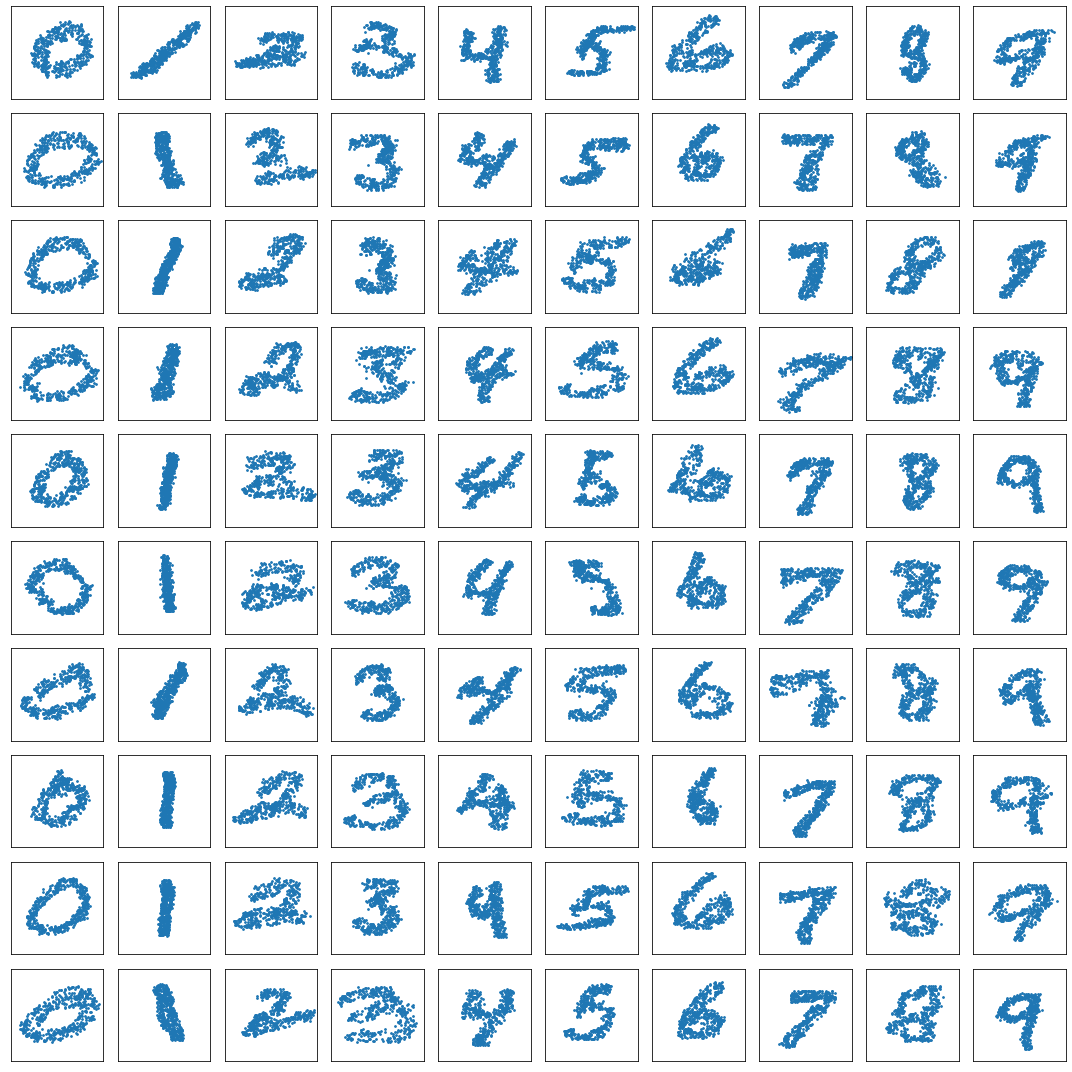

Epoch: 27; Batch: 197/1875; Generator loss: 1.3479158878326416; Discriminator loss: 0.5445221662521362

KeyboardInterrupt: 

In [186]:
# Training Loop
with strategy.scope():
    num_batches = int(60000 / GLOBAL_BATCH_SIZE)
    
    data_iterator = iter(train_dist_dataset)
    
    while True:
        
        test()
        
        start = time.time()
        disc_loss = 0
        gen_loss = 0
        for i in range(num_batches):
            batch = next(data_iterator)
            losses = distributed_train_step(batch, k)
            disc_loss += losses[0]
            gen_loss += losses[1]
            print(f"\rEpoch: {epoch+1}; Batch: {i+1}/{num_batches}; Generator loss: {gen_loss/(i+1)}; Discriminator loss: {disc_loss/(i+1)}", end="")
        disc_losses.append(disc_loss / (i+1))
        gen_losses.append(gen_loss / (i+1))
        epoch += 1
        
        lr_schedule([gen_optimizer, disc_optimizer])
        
        if epoch % 10 == 0:
            model.save_weights(f"gast_epoch_{epoch}.h5")
        
        tf.print(f"Epoch {epoch} completed in {time.time() - start:.2f} seconds. Generator loss: {gen_losses[-1]}; Discriminator loss: {disc_losses[-1]}", end="\r")

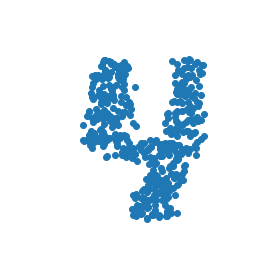

In [324]:
digit = 4
num_points = 500

plt.figure(figsize=(4, 4))
plt.scatter(*tf.transpose(generator((tf.random.normal((1, LATENT_DIM)), tf.constant([digit]), tf.constant([num_points])))[0]))
plt.xlim((-3, 3))
plt.ylim((-3, 3))
plt.axis(False)
plt.tight_layout()
plt.show()

In [297]:
model.save_weights("acgast.h5")

In [ ]:
test("./images/acgast.png")